In [36]:
#import libraries
import pandas as pd
import numpy as np
import csv
import ast
import re
from prettytable import PrettyTable

from collections import Counter

import time
import random

#data visualization libraries
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

#NLP & ML libraries
from gensim.models import Word2Vec
from gensim.utils import tokenize
from gensim.models.phrases import Phrases
from textblob import TextBlob
from nltk import FreqDist

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

from scipy.sparse import save_npz, load_npz

In [2]:
#set seed so that code output is deterministic
random.seed(30)  # Set the seed for Python's random module
np.random.seed(30)  # Set the seed for NumPy's random module

In [3]:
#import cleaned data

def list_converter(text):
    #to revert list->str conversion from pd.read_csv
    return ast.literal_eval(text)


data = pd.read_csv('Data/training_corpus.csv', converters ={'tokens':list_converter})

In [4]:
data = data.drop(columns = ['index'])
print (data.shape)
data.head()

(99186, 7)


,text_type,ID,year,long_text,clean_text,word_count,tokens
0,comment,gtfo2hl,2021,"*Cuntry roads, take me hoem*",cuntry roads hoem,3,"[cuntry, road, hoem]"
1,comment,gtfqkbv,2021,"That’s been there for several years, sent a pi...",years sent pic cuntry friend long time ago,8,"[year, send, pic, cuntry, friend, long, time, ..."
2,comment,gtfou07,2021,I am single and I have not traveled to any cun...,single traveled cuntry past year,5,"[single, travel, cuntry, past, year]"
3,comment,gtfrgpe,2021,What happens when you shop at dragon mart...,happens shop dragon mart,4,"[happen, shop, dragon, mart]"
4,comment,gthiiwi,2021,"That’s just absolutely hilarious, is this in t...",absolutely hilarious springs souk,4,"[absolutely, hilarious, spring, souk]"


In [5]:
#include column with additional stopwords removal
#created the filtered corpus from another notebook and imported it here for use
# Read the file
with open('updated_corpus.txt', 'r') as f:
    updated_tokens = f.readlines()

# Remove newline characters
updated_tokens = [line.strip() for line in updated_tokens]


data['updated_tokens'] = updated_tokens

In [6]:

#convert list of strings to dataframe column with list of tokens on each row
data['updated_tokens'] = data['updated_tokens'].apply(lambda x: list(tokenize(x)))

In [7]:
#dataframe of all empty token lists due to removal of additional stopwords
empty_tokens = data[data['updated_tokens'].apply(lambda x: len(x) == 0)]

empty_tokens.shape

(2793, 8)

In [8]:
#adjust corpus to remvoe rows with empty token lists
row_id = empty_tokens['ID'] #id of rows with empty token list

updated_data = data[~data['ID'].isin(row_id)]
updated_data

,text_type,ID,year,long_text,clean_text,word_count,tokens,updated_tokens
0,comment,gtfo2hl,2021,"*Cuntry roads, take me hoem*",cuntry roads hoem,3,"[cuntry, road, hoem]",[road]
2,comment,gtfou07,2021,I am single and I have not traveled to any cun...,single traveled cuntry past year,5,"[single, travel, cuntry, past, year]","[single, travel, past]"
3,comment,gtfrgpe,2021,What happens when you shop at dragon mart...,happens shop dragon mart,4,"[happen, shop, dragon, mart]","[shop, dragon, mart]"
4,comment,gthiiwi,2021,"That’s just absolutely hilarious, is this in t...",absolutely hilarious springs souk,4,"[absolutely, hilarious, spring, souk]","[hilarious, spring, souk]"
6,comment,gtfw6yj,2021,Eugene's first day as a signwriter for Country...,eugene s day signwriter country artificial pro...,8,"[eugene, s, day, signwriter, country, artifici...","[artificial, product, expect]"
...,...,...,...,...,...,...,...,...
99181,submission,14f46ji,2023,"Best beauty saloons in Dubai? Hello fellas, I ...",best beauty saloons dubai hello fellas moved w...,35,"[good, beauty, saloon, dubai, hello, fellas, m...","[beauty, saloon, hello, wife, real, saloon, re..."
99182,submission,14f4uyi,2023,Found the r/dubai redditors who kept telling m...,found r dubai redditors kept telling know navi...,10,"[find, r, dubai, redditor, keep, tell, know, n...","[navigate, roundabout]"
99183,submission,14f4ri3,2023,Scam ? Healthy.line My sister has a CBD debit ...,scam healthy line sister cbd debit card month ...,47,"[scam, healthy, line, sister, cbd, debit, card...","[scam, healthy, line, sister, cbd, debit, card..."
99184,submission,14f4k3r,2023,Thoughts on Expo City properties? Anyone else ...,thoughts expo city properties checked expo cit...,21,"[thought, expo, city, property, check, expo, c...","[expo, property, expo, sale, page, pleasant, d..."


## **Word2Vec Model** 

### FULL CORPUS -->After initial preprocessing

In [9]:
#convert df['tokens'] to list of strings for word2vec model
corpus = data['tokens'].tolist()#.apply(lambda token: ' '.join(token)).tolist()

corpus[:5]

[['cuntry', 'road', 'hoem'],
 ['year', 'send', 'pic', 'cuntry', 'friend', 'long', 'time', 'ago'],
 ['single', 'travel', 'cuntry', 'past', 'year'],
 ['happen', 'shop', 'dragon', 'mart'],
 ['absolutely', 'hilarious', 'spring', 'souk']]

In [10]:
#code from codebasics and semicolon, both on youtube

#instantiate word2vec model
full_corpus_model = Word2Vec (window = 5, min_count = 2, workers = 4, vector_size = 300)
   
#build a vocabulary
full_corpus_model.build_vocab(corpus, progress_per = 1000)

In [11]:
full_corpus_model.corpus_count #number of sentences/documents

99186

In [14]:
#train the word2vec model

full_corpus_model.train(
                corpus,
                total_examples = full_corpus_model.corpus_count,
                epochs = full_corpus_model.epochs
)

full_corpus_model.save('pretrained_models/full_corpus_model.model') #save model locally

In [41]:
num_unique_words = len(full_corpus_model.wv.index_to_key)
print(f"Number of unique words in the vocabulary: {num_unique_words}")


Number of unique words in the vocabulary: 21945


In [15]:
full_corpus_model.wv.most_similar ('lulu')

[('nesto', 0.9041059613227844),
 ('hypermarket', 0.8900609612464905),
 ('viva', 0.8795011639595032),
 ('spinney', 0.8684303164482117),
 ('waitrose', 0.8657668232917786),
 ('carrefour', 0.8637438416481018),
 ('cafeteria', 0.86180579662323),
 ('kebab', 0.8451476693153381),
 ('fish', 0.830316424369812),
 ('fruit', 0.8197862505912781)]

In [16]:
full_corpus_model.wv.most_similar('reddit')

[('sub', 0.8014408349990845),
 ('subreddit', 0.7356389760971069),
 ('forum', 0.6882253289222717),
 ('rant', 0.661300539970398),
 ('ama', 0.6551594138145447),
 ('pooh', 0.6432737708091736),
 ('mod', 0.6386380791664124),
 ('bash', 0.6302337050437927),
 ('post', 0.6245636940002441),
 ('troll', 0.6224903464317322)]

In [17]:
full_corpus_model.wv.doesnt_match(['ejari', 'rera', 'dewa', 'drive'])

'drive'

## **Word2Vec Model** with custom stopwords removed from corpus

In [18]:
#convert ['tokens'] column to list of strings for word2vec model
filtered_corpus = updated_data['updated_tokens'].tolist()

filtered_corpus[:5]

[['road'],
 ['single', 'travel', 'past'],
 ['shop', 'dragon', 'mart'],
 ['hilarious', 'spring', 'souk'],
 ['artificial', 'product', 'expect']]

In [20]:
#code from codebasics and semicolon, both on youtube

#instantiate word2vec model on filtered corpus
filtered_corpus_model = Word2Vec (window = 5, min_count = 2, workers = 4)
   
#build a vocabulary
filtered_corpus_model.build_vocab(filtered_corpus, progress_per = 1000)



In [21]:
#number of sentences in vocabulary
filtered_corpus_model.corpus_count

96393

In [23]:
#train the word2vec model

filtered_corpus_model.train(
                filtered_corpus,
                total_examples = filtered_corpus_model.corpus_count,
                epochs = filtered_corpus_model.epochs
)

filtered_corpus_model.save('pretrained_models/filtered_corpus_model.model') #save model locally

In [43]:
num_unique_words = len(filtered_corpus_model.wv.index_to_key)
print(f"Number of unique words in the vocabulary: {num_unique_words}")

Number of unique words in the vocabulary: 7915


In [33]:
filtered_corpus_model.wv.most_similar ('lulu')

[('spinney', 0.923656702041626),
 ('nesto', 0.9187120199203491),
 ('hypermarket', 0.9102887511253357),
 ('viva', 0.8983575701713562),
 ('carrefour', 0.8950652480125427),
 ('waitrose', 0.8810536861419678),
 ('avocado', 0.8634451031684875),
 ('kg', 0.8579152822494507),
 ('cafeteria', 0.8487486839294434),
 ('shelf', 0.848399817943573)]

In [34]:
filtered_corpus_model.wv.most_similar ('fish')

[('spice', 0.9297316074371338),
 ('pickle', 0.885685384273529),
 ('dessert', 0.8707259893417358),
 ('vegetable', 0.8670319318771362),
 ('garlic', 0.8658277988433838),
 ('falafel', 0.8650765419006348),
 ('seafood', 0.8641912937164307),
 ('delicious', 0.863122820854187),
 ('lamb', 0.8630397319793701),
 ('grill', 0.858243465423584)]

In [35]:
filtered_corpus_model.wv.most_similar ('bridge')

[('khail', 0.857735276222229),
 ('tunnel', 0.8369247913360596),
 ('roundabout', 0.823350727558136),
 ('szr', 0.8155798316001892),
 ('footpath', 0.7897583246231079),
 ('intersection', 0.7877615690231323),
 ('interchange', 0.7850115895271301),
 ('qudra', 0.784199595451355),
 ('quoz', 0.7816630005836487),
 ('gate', 0.7742656469345093)]

In [30]:
filtered_corpus_model.wv.most_similar('reddit')

KeyError: "Key 'reddit' not present in vocabulary"

## **Word2Vec with bigrams**

In [37]:
#first model on full corpus

#code from gensim documentation

#train bigram detector
bigram_transform = Phrases (corpus, min_count = 1) #default threshold is 10.0, fewer phrases will be created

In [38]:
#check performance of bigram transform model
new_sentence = corpus[330]
print(bigram_transform[new_sentence])

['anymore', 'new', 'labor_law', 'common', 'blatant', 'good', 'company', 'care', 'sale', 'promotional', 'bdm', 'post', 'hire', 'look', 'filter', 'photo_cv', 'rife', 'real_estate', 'industry', 'say', 'uae', 'young', 'country', 'learn', 'motivation', 'law', 'change', 'align', 'progressive', 'practice', 'ahead', 'way', 'nature', 'place', 'live']


In [40]:
#create corpus with bigrams
bigram_full_corpus = [bigram_transform[sentence] for sentence in corpus]

#code from codebasics and semicolon, both on youtube

#instantiate word2vec model
bigram_full_corpus_model = Word2Vec (window = 5, min_count = 2, workers = 4, vector_size = 300)
   
#build a vocabulary
bigram_full_corpus_model.build_vocab(bigram_full_corpus, progress_per = 1000)

In [44]:
bigram_full_corpus_model.corpus_count

99186

In [61]:
#train the word2vec model

bigram_full_corpus_model.train(
                bigram_full_corpus,
                total_examples = bigram_full_corpus_model.corpus_count,
                epochs = bigram_full_corpus_model.epochs
)

bigram_full_corpus_model.save('pretrained_models/bigram_full_corpus_model.model') #save model locally

In [62]:
num_unique_words = len(bigram_full_corpus_model.wv.index_to_key)
print(f"Number of unique words in the vocabulary: {num_unique_words}")

Number of unique words in the vocabulary: 52736


In [63]:
bigram_full_corpus_model.wv.most_similar('lulu')

[('cafeteria', 0.9247283935546875),
 ('nesto', 0.9211819767951965),
 ('biryani', 0.9193111062049866),
 ('vegetable', 0.9186529517173767),
 ('waitrose', 0.9166808128356934),
 ('spinney', 0.9066855311393738),
 ('cheese', 0.9045244455337524),
 ('garlic', 0.904297411441803),
 ('hummus', 0.9040725827217102),
 ('grill', 0.9039145708084106)]

In [65]:
bigram_full_corpus_model.wv.most_similar('real_estate')

[('estate', 0.8535524606704712),
 ('night_entertainment', 0.8352311849594116),
 ('property', 0.809614896774292),
 ('developer', 0.7964819073677063),
 ('broker', 0.790652871131897),
 ('market', 0.7798449397087097),
 ('contribute_skyrocket', 0.7744459509849548),
 ('buy_property', 0.7545173764228821),
 ('purchase_unit', 0.7541970014572144),
 ('agent', 0.7453875541687012)]

In [66]:
bigram_full_corpus_model.wv.most_similar('reddit')

[('subreddit', 0.876783549785614),
 ('sub', 0.869361937046051),
 ('r_dubai', 0.836040735244751),
 ('mod', 0.8131747245788574),
 ('thread', 0.7981452941894531),
 ('forum', 0.7869880199432373),
 ('recent_post', 0.7811811566352844),
 ('sub_reddit', 0.7561783194541931),
 ('delete', 0.7503645420074463),
 ('stand_microphone', 0.739766538143158)]

In [67]:
#second model on filtered corpus 
#create corpus with bigrams
bigram_filtered_corpus = [bigram_transform[sentence] for sentence in filtered_corpus]

#code from codebasics and semicolon, both on youtube

#instantiate word2vec model
bigram_filtered_corpus_model = Word2Vec (window = 5, min_count = 2, workers = 4, vector_size = 300)
   
#build a vocabulary
bigram_filtered_corpus_model.build_vocab(bigram_filtered_corpus, progress_per = 1000)


In [68]:
bigram_filtered_corpus_model.corpus_count

96393

In [69]:
#train the word2vec model

bigram_filtered_corpus_model.train(
                bigram_filtered_corpus,
                total_examples = bigram_filtered_corpus_model.corpus_count,
                epochs = bigram_filtered_corpus_model.epochs
)

bigram_filtered_corpus_model.save('pretrained_models/bigram_filtered_corpus_model.model') #save model locally

In [70]:
num_unique_words = len(bigram_filtered_corpus_model.wv.index_to_key)
print(f"Number of unique words in the vocabulary: {num_unique_words}")

Number of unique words in the vocabulary: 31385


In [72]:
bigram_filtered_corpus_model.wv.most_similar('real_estate')

[('property', 0.9869977235794067),
 ('market', 0.9855281710624695),
 ('invest', 0.9831932783126831),
 ('value', 0.9785251021385193),
 ('agent', 0.9784762263298035),
 ('sale', 0.9767586588859558),
 ('cancel_ejari', 0.9749554395675659),
 ('depreciation_appreciation', 0.971201479434967),
 ('investment', 0.9695356488227844),
 ('negotiate_landlord', 0.9667245149612427)]

In [73]:
bigram_filtered_corpus_model.wv.most_similar('reddit')

KeyError: "Key 'reddit' not present in vocabulary"

### **WORD CLUSTERING WITH WORD2VEC MODEL**

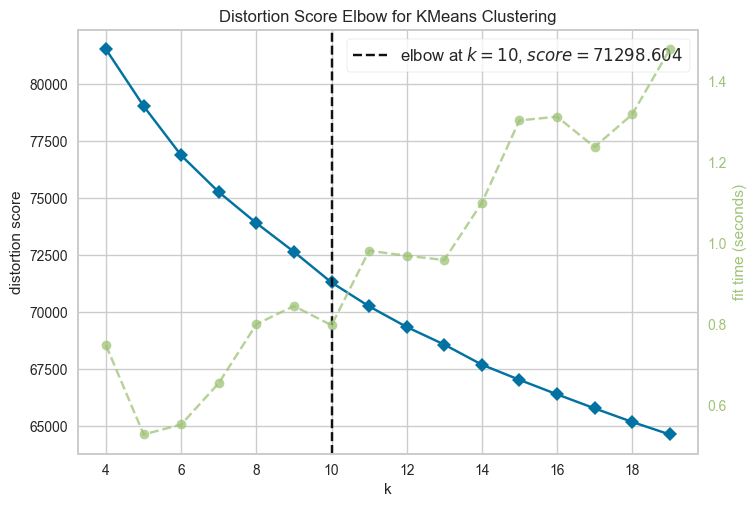

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [83]:
word_vectors = filtered_corpus_model.wv.vectors #2d word vectors for clustering

#determine optimum k-clusters using yellowbrick visualizer


kmeans = KMeans(init = 'k-means++', n_init = 10, max_iter = 200, random_state = 0)
visualizer = KElbowVisualizer(kmeans, k = (4,20))

visualizer.fit(word_vectors)
visualizer.show()



In [95]:
num_clusters = 14  # This is just an example, replace with your chosen number

# Perform KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=200, n_init=10, random_state=0)
kmeans.fit(word_vectors)

# Now each word in your vocabulary is assigned to a cluster
word_clusters = kmeans.labels_

# You can create a mapping of words to their assigned clusters
word_to_cluster = {word: cluster for word, cluster in zip(filtered_corpus_model.wv.index_to_key, word_clusters)}

# Now you can print the words in each cluster
for i in range(num_clusters):
    words_in_cluster = [word for word, cluster in word_to_cluster.items() if cluster == i]
    print(f"Cluster {i}: {words_in_cluster[:10]}")

Cluster 0: ['give', 'real', 'bring', 'deal', 'one', 'show', 'similar', 'include', 'possible', 'single']
Cluster 1: ['take', 'read', 'safe', 'have', 'learn', 'face', 'parent', 'child', 'hold', 'god']
Cluster 2: ['food', 'restaurant', 'eat', 'shop', 'store', 'drink', 'brand', 'chicken', 'taste', 'prefer']
Cluster 3: ['area', 'mall', 'walk', 'visit', 'building', 'abu', 'public', 'dhabi', 'night', 'sharjah']
Cluster 4: ['usually', 'couple', 'date', 'enjoy', 'wonder', 'notice', 'play', 'half', 'early', 'fun']
Cluster 5: ['case', 'test', 'covid', 'mask', 'risk', 'health', 'daily', 'control', 'vaccine', 'result']
Cluster 6: ['indian', 'india', 'middle', 'expat', 'uk', 'arab', 'arabic', 'compare', 'example', 'english']
Cluster 7: ['water', 'house', 'outside', 'break', 'cool', 'door', 'cover', 'sit', 'clean', 'inside']
Cluster 8: ['law', 'culture', 'rule', 'news', 'non', 'state', 'opinion', 'muslim', 'human', 'community']
Cluster 9: ['experience', 'etc', 'business', 'family', 'local', 'governme

## **CREATE DOCUMENT VECTORS FROM WORD EMBEDDINGS**

In [96]:
#create document vectors using average of word vectors

#code from Dylan Castillo https://dylancastillo.co/nlp-snippets-cluster-documents-using-word2vec/#train-word2vec-model

def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
vectorized_docs = vectorize(updated_data['updated_tokens'].values, model=filtered_corpus_model)
len(vectorized_docs), len(vectorized_docs[0])

(96393, 100)

In [97]:
type(vectorized_docs[330])

numpy.ndarray

In [98]:
print(np.array(vectorized_docs).ndim)

2


In [ ]:
#do some document similarity things

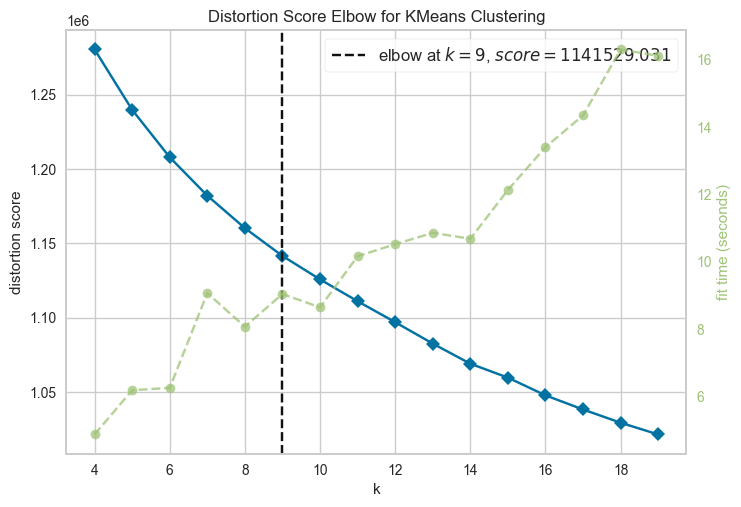

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [99]:
#determine optimum k-clusters using yellowbrick visualizer


kmeans = KMeans(init = 'k-means++', n_init = 10, random_state = 0)
visualizer = KElbowVisualizer(kmeans, k = (4,20))

visualizer.fit(np.array(vectorized_docs))
visualizer.show()


In [102]:
true_k = 14

model = KMeans(n_clusters=true_k, init="k-means++", max_iter=100, n_init=10, random_state = 12)

model.fit(np.array(vectorized_docs))

# Assign each document to a cluster
clusters = model.predict(np.array(vectorized_docs))

# For each cluster
for i in range(true_k):
    print(f"Cluster {i}:")

    # Find all the documents that belong to this cluster
    docs_in_cluster = [doc for doc, cluster in zip(updated_data['updated_tokens'].values, clusters) if cluster == i]

    # Count the frequency of each word in these documents
    word_freq = Counter(word for doc in docs_in_cluster for word in doc)

    # Print the 10 words with the highest frequency
    for word, freq in word_freq.most_common(10):
        print(f"    {word}")


Cluster 0:
    news
    message
    read
    google
    call
    website
    ad
    app
    article
    whatsapp
Cluster 1:
    business
    experience
    real
    etc
    family
    market
    government
    take
    low
    give
Cluster 2:
    police
    fine
    report
    case
    law
    take
    security
    court
    illegal
    complaint
Cluster 3:
    take
    stop
    walk
    give
    call
    cat
    night
    play
    drive
    fun
Cluster 4:
    buy
    price
    sell
    cost
    rent
    cheap
    market
    property
    expensive
    apartment
Cluster 5:
    water
    hot
    summer
    heat
    cold
    air
    weather
    rain
    cool
    clean
Cluster 6:
    visa
    salary
    passport
    apply
    tax
    employee
    employer
    wage
    income
    offer
Cluster 7:
    food
    eat
    chicken
    restaurant
    burger
    taste
    shawarma
    order
    milk
    drink
Cluster 8:
    card
    delivery
    service
    app
    order
    bank
    tip
    credit